# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *R*

**Names:**

* *Raphael Barman*
* *Thierry Bossy*
* *Raphael Strebel*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics

#### Exercise 2.9: Simulate an epidemic outbreak

In [7]:
import epidemics_helper
import json
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# Load the data of nyc network
with open('../data/nyc_augmented_network.json') as data_file:    
    data = json.load(data_file)
    
graph = nx.Graph()

nb_edges = len(data['links']) - 1

# Construct the graph edge by edge (there has to be a nicer way)
for i in range(0, nb_edges):
    graph.add_edge(data['links'][i]['source'], data['links'][i]['target'])

print("Number of nodes:", nx.number_of_nodes(graph))
print("Number of edges:", nb_edges)

Number of nodes: 26481
Number of edges: 43436
Number of edges: 43436


In [3]:
# Build the continuous-time SIR epidemic
sir = epidemics_helper.SimulationSIR(graph, beta=10.0, gamma=0.1)

# Launch epidemic
sir.launch_epidemic(source=23654, max_time=100.0)

Epidemic stopped after 101.49 days | 101.49 days elapsed | 0.2% susceptible, 0.0% infected, 99.8% recovered


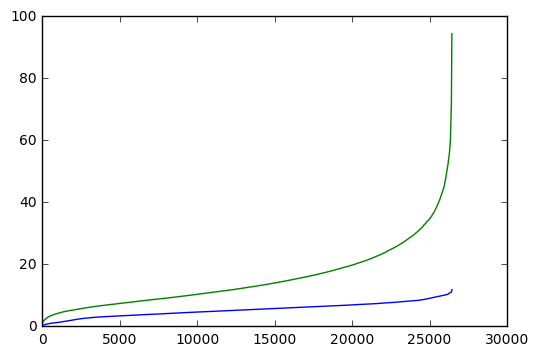

In [11]:
# plotting values
plt.plot(sorted(sir.inf_time))
plt.plot(sorted(sir.rec_time))

# finding number of infections, susceptible and recovered
nb_nodes = nx.number_of_nodes(graph)
nb_susc = nb_nodes
nb_inf = 0
nb_rec = 0

# on doit plot nb d'infectés ect en fonction du temps, donc on doit regarder pour chaque temps le nombre d'inf ect? 
# Idée: sort les inf et rec times 

for i in range(0, nb_nodes):
    if(sir.inf_time[i] == np.inf):
        nb_inf += 1
    elif(sir.rec_time[i] != np.inf):
        nb_rec += 1
        nb_inf -= 1

---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

#### Exercise 2.11: Strategy 2